## Zillow Regression with Clustering Project

### Project Goals

- The goal of this project is to find features or clusters of features to improve Zillow's log error for single family residences in three Southern California counties and to use these features to develop an improved machine learning model.

- Our initial hypothesis is that the size of the home in square feet, the age of the home, and the location are the main features affecting log error.

- Initial questions:
    - What is the relationship between square feet and log error? Do area clusters have a large impact on the overall log error?
    - Does the size of the home affect log error? Can that error be better determined by clustering by size?
    - Does the location have an effect on log error? Where does the most log error occur?

### Project Planning

- Acquire the dataset from the Codeup database using SQL
- Prepare the data with the intent to improve the log error from Zestimates; clean the data and encode categorical features if necessary; ensure that the data is tidy
- Split the data into train, validate, and test datasets using a 60/20/20 split
- Explore the data:
    - Univariate, bivariate, and multivariate analyses; statistical tests for significance, find the three primary features or clusters affecting log error
    - Create graphical representations of the analyses
    - Answer questions about the data
    - Document findings
- Train and test at least three models:
    - Establish a baseline
    - Select key features and train multiple linear regression models
    - Test the model on the validate set, adjust for overfitting if necessary
- Select the best model for the project goals:
    - Determine which model performs best on the validate set
- Test and evaluate the model:
    - Use the model on the test set and evaluate its performance (RMSE, R2, etc.)
    - Visualize the data using an array of probabilities on the test set
- Document key findings and takeaways, answer the questions
    
### Executive Summary

- After running four models on my train and validate sets, we decided to use the polynomial linear regression model because it provided the lowest RMSE compared to baseline.

- We selected the features for modeling based on statistical analysis (square feet of the home, ratio of bedrooms and bathrooms, lot size, age, number of bathrooms, area cluster, and size cluster). We selected a degree multiplier of 2. The RMSE of the selected model was .162 on train, .143 on validate, and .174 on test.

- Takeaways: the selected features improved the overall log error, but not much more than baseline. The clusters did not significantly reduce the RMSE, but there was a very small improvement when using the absolute value for the log error. Overall, none of the models significantly outperformed Zillow's current model.

### Acquire and Prepare Data

In [38]:
# standard imports for full data pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import os
from math import sqrt
# imports for project-specific functions
import env
import wrangle
import model
import explore
# sklearn imports for modeling, splitting, scaling
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import warnings
warnings.filterwarnings('ignore')

In [39]:
# full zillow database
wrangle.full_zillow_db()

,id,parcelid,logerror,transactiondate,airconditioningtypeid,airconditioningdesc,architecturalstyletypeid,architecturalstyledesc,basementsqft,bathroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,1,10759547,0.055619,2017-01-01,NaN,None,NaN,None,NaN,0.0,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,None,NaN,NaN
1,15,11193347,0.008669,2017-01-02,NaN,None,NaN,None,NaN,0.0,...,NaN,NaN,NaN,10.0,2016.0,10.0,NaN,None,NaN,NaN
2,16,11215747,-0.021896,2017-01-02,NaN,None,NaN,None,NaN,0.0,...,NaN,NaN,NaN,10.0,2016.0,10.0,NaN,None,NaN,NaN
3,17,11229347,-0.017167,2017-01-02,NaN,None,NaN,None,NaN,0.0,...,NaN,NaN,NaN,2108.0,2016.0,2108.0,174.21,None,NaN,NaN
4,20,11324547,0.042463,2017-01-02,1.0,Central,NaN,None,NaN,2.0,...,NaN,NaN,222321.0,296425.0,2016.0,74104.0,6941.39,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56075,77608,11212264,-0.002245,2017-09-20,1.0,Central,NaN,None,NaN,2.0,...,NaN,NaN,137951.0,180715.0,2016.0,42764.0,3677.13,None,NaN,6.037911e+13
56076,77609,11212539,0.020615,2017-09-20,1.0,Central,NaN,None,NaN,3.0,...,NaN,NaN,129566.0,162019.0,2016.0,32453.0,2860.33,None,NaN,6.037911e+13
56077,77610,11212639,0.013209,2017-09-21,1.0,Central,NaN,None,NaN,3.0,...,NaN,NaN,100744.0,125923.0,2016.0,25179.0,2394.26,None,NaN,6.037911e+13
56078,77611,11212962,0.037129,2017-09-21,1.0,Central,NaN,None,NaN,2.0,...,NaN,NaN,149241.0,198988.0,2016.0,49747.0,3331.81,None,NaN,6.037911e+13


In [40]:
# acquire database using function from wrangle.py and save to a variable
df = wrangle.wrangle_zillow()

In [41]:
# verify successful wrangling of data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50699 entries, 0 to 52441
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      50699 non-null  int64  
 1   logerror                      50699 non-null  float64
 2   bathroomcnt                   50699 non-null  float64
 3   bedroomcnt                    50699 non-null  float64
 4   calculatedfinishedsquarefeet  50699 non-null  float64
 5   fips                          50699 non-null  float64
 6   latitude                      50699 non-null  float64
 7   longitude                     50699 non-null  float64
 8   lotsizesquarefeet             50699 non-null  float64
 9   regionidcity                  50699 non-null  float64
 10  regionidcounty                50699 non-null  float64
 11  regionidzip                   50699 non-null  float64
 12  yearbuilt                     50699 non-null  float64
 13  s

In [42]:
# verify proper encoding of fips into counties
wrangle.verify_counties(df)

LA County Verified:  True
Orange County Verified:  True
Ventura County Verified:  True


### Acquisition and Preparation Takeaways

- The dataset was acquired from the Codeup database using a SQL query.

- Data was limited to homes with a transaction in 2017, homes with more than 0 and less than 8 bedrooms, more than 0 and less than 8 bathrooms, home size less than 10,000 square feet, homes with less than 20 acres, and homes with a tax rate less than 30. All observations with null values were removed. 

- FIPS was encoded and new features (age, age_bin, taxrate, acres, acres_bin, sqft_bin, structure_dollar_per_sqft, structure_dollar_per_sqft_bin, land_dollar_per_sqft, lot_dollar_sqft_bin) were created.

- The cleaned dataset has 50699 observations and 29 columns. All columns are integers or floats.

- The dataset has been split into train, validate, and test sets using a 60/20/20 split.

## Exploration

In [43]:
# split the data into train, validate, and test sets
train, X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle.split(df, target_var='logerror')

In [44]:
# bin logerror
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

In [45]:
# scale features and concatenate to train, validate, and test datasets; MinMax scaler was fit to train only
X_train = explore.fit_scale_and_concat(X_train, X_train)
X_validate = explore.fit_scale_and_concat(X_validate, X_train)
X_test = explore.fit_scale_and_concat(X_test, X_train)

In [46]:
# verify successful concatenation
X_train.describe()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,...,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,scaled_latitude,scaled_longitude,scaled_bathroomcnt,scaled_taxrate,scaled_calculatedfinishedsquarefeet,scaled_age
count,3.041900e+04,30419.000000,30419.000000,30419.000000,30419.000000,3.041900e+04,3.041900e+04,30419.000000,30419.000000,30419.000000,...,30419.000000,30419.000000,30419.000000,30419.000000,30419.000000,30419.000000,30419.000000,30419.000000,30419.000000,30419.000000
mean,1.296492e+07,2.280910,3.295177,1895.558598,6049.228081,3.402238e+07,-1.181954e+08,9851.551925,33750.851409,2525.603044,...,0.278648,48.077390,0.288928,0.696514,0.461141,0.667920,0.213485,0.044840,0.179822,0.383181
std,2.452114e+06,0.971538,0.912588,934.202991,21.184564,2.726243e+05,3.565038e+05,20731.932367,50470.504983,802.691943,...,0.146563,72.474163,0.128671,0.234051,0.184465,0.190037,0.161923,0.015596,0.096349,0.165140
min,1.071186e+07,1.000000,1.000000,152.000000,6037.000000,3.334085e+07,-1.194484e+08,236.000000,3491.000000,1286.000000,...,0.000000,0.027992,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.150588e+07,2.000000,3.000000,1264.000000,6037.000000,3.382851e+07,-1.183989e+08,5562.500000,12447.000000,1286.000000,...,0.200000,9.342151,0.200000,0.500000,0.329965,0.559464,0.166667,0.039154,0.114686,0.275362
50%,1.257532e+07,2.000000,3.000000,1647.000000,6037.000000,3.402074e+07,-1.181555e+08,6813.000000,24812.000000,3101.000000,...,0.300000,30.070068,0.300000,0.666667,0.460030,0.689163,0.166667,0.041505,0.154187,0.405797
75%,1.413053e+07,3.000000,4.000000,2275.000000,6059.000000,3.418624e+07,-1.179295e+08,8711.000000,40227.000000,3101.000000,...,0.400000,59.898043,0.400000,0.800000,0.572013,0.809639,0.333333,0.046043,0.218956,0.478261
max,1.629608e+08,7.000000,7.000000,9848.000000,6111.000000,3.481877e+07,-1.175724e+08,677428.000000,396556.000000,3101.000000,...,0.900000,1882.546201,0.900000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
# list of variables I will cluster on. 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'age_bin']
# cluster column name
cluster_name = 'area_cluster'
# range for find_k
k_range = range(2,10)

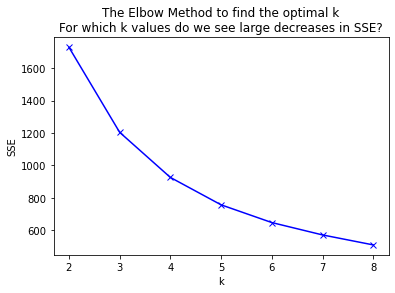

,k,sse
0,2,1729.125105
1,3,1204.248755
2,4,925.793415
3,5,756.659071
4,6,647.233472
5,7,570.933562
6,8,509.334777


In [48]:
# graph find_k using the SSE
explore.find_k(X_train, cluster_vars, k_range)

In [49]:
# select best number for centroids according to elbow method
k = 5
# create the clusters using function from explore.py
kmeans = explore.create_clusters(X_train, k, cluster_vars)
# create dataframe for the clusters
centroid_df = explore.get_centroids(kmeans, cluster_vars, cluster_name)

In [50]:
# confirm that the dataframe was created successfully
centroid_df

,area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_age_bin
0,0,0.377058,0.767313,0.411497
1,1,0.610202,0.347941,0.298327
2,2,0.218567,0.896596,0.226193
3,3,0.499836,0.595741,0.539269
4,4,0.846113,0.690963,0.231445


In [51]:
# assign the clusters to train, validate, and test for modeling
X_train = explore.assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)
X_validate = explore.assign_clusters(X_validate, kmeans, cluster_vars, cluster_name, centroid_df)
X_test = explore.assign_clusters(X_test, kmeans, cluster_vars, cluster_name, centroid_df)

In [52]:
# show the centroids and number of homes for each area cluster
pd.DataFrame(X_train.groupby(['area_cluster', 'centroid_scaled_latitude', 'centroid_scaled_longitude', 
                           'centroid_age_bin'])['area_cluster'].count())

,,,,area_cluster
area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_age_bin,
0,0.377058,0.767313,0.411497,10034
1,0.610202,0.347941,0.298327,4629
2,0.218567,0.896596,0.226193,4617
3,0.499836,0.595741,0.539269,8713
4,0.846113,0.690963,0.231445,2426


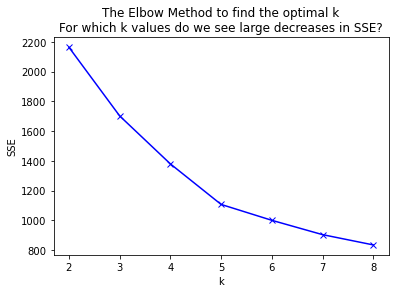

,k,sse
0,2,2163.355315
1,3,1702.011658
2,4,1379.559438
3,5,1107.222724
4,6,1000.431163
5,7,904.151256
6,8,835.130457


In [53]:
# select features for size cluster
cluster_vars = ['scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio']
cluster_name = 'size_cluster'
k_range = range(2,10)
# graph find_k using SSE to select the best k
explore.find_k(X_train, cluster_vars, k_range)

In [54]:
# select number of centroids using elbow method above
k=5
# fit kmeans 
kmeans = explore.create_clusters(X_train, k, cluster_vars)
# get centroid values per variable per cluster
centroid_df = explore.get_centroids(kmeans, cluster_vars, cluster_name)
# get cluster assignments and append those with centroids for each X dataset (train, validate, test)
X_train = explore.assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)
X_validate = explore.assign_clusters(X_validate, kmeans, cluster_vars, cluster_name, centroid_df)
X_test = explore.assign_clusters(X_test, kmeans, cluster_vars, cluster_name, centroid_df)

In [55]:
# show the centroids and number of homes for each size cluster
pd.DataFrame(X_train.groupby(['size_cluster', 'centroid_scaled_bathroomcnt', 'centroid_sqft_bin',
                              'centroid_acres_bin', 'centroid_bath_bed_ratio'])['area_cluster'].count())

,,,,,area_cluster
size_cluster,centroid_scaled_bathroomcnt,centroid_sqft_bin,centroid_acres_bin,centroid_bath_bed_ratio,
0,0.009566,0.178265,0.125160,0.428186,5636
1,0.329511,0.569997,0.203134,0.715053,6126
2,0.168561,0.345028,0.163000,0.615203,11746
3,0.546761,0.698981,0.261245,1.112544,2650
4,0.232966,0.354612,0.124548,0.990184,4261


### Are the sizes of homes different based on area cluster? Are newer homes larger than older homes? Where are the newer homes located?

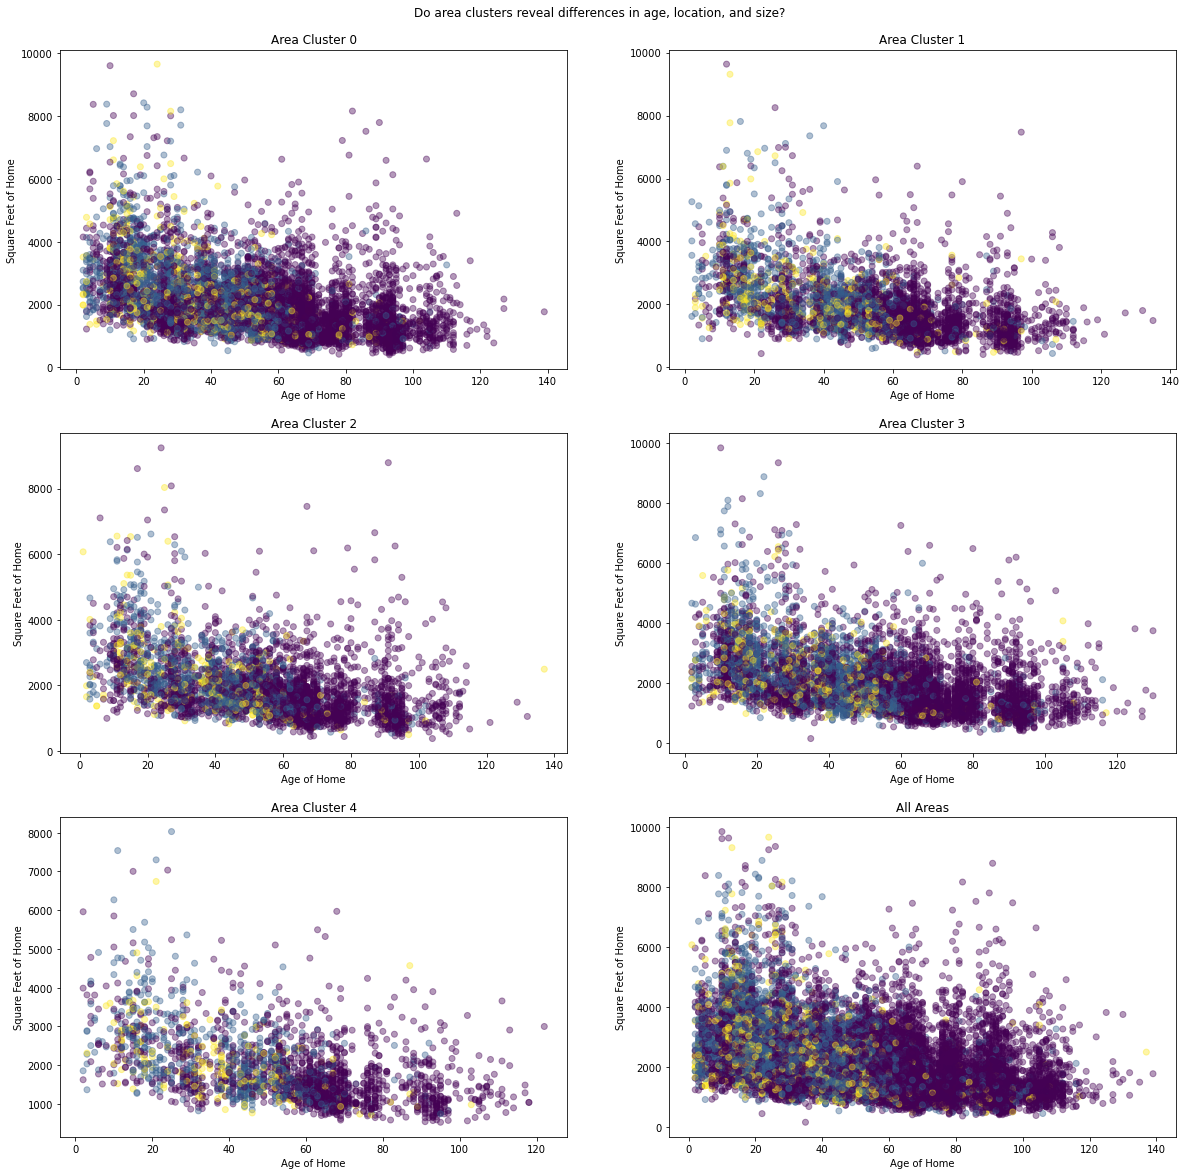

In [56]:
# plot visualizations of age of home and square footage for each area cluster
explore.plot_age_sqft(X_train)

#### Statistical Test

- H0: There is no relationship between the age of the home and the square feet of the home.
- Ha: There is a relationship between the age of the home and the square feet of the home.

In [57]:
# conduct spearman test for age and square footage
explore.spearman_test(X_train.age, X_train.scaled_calculatedfinishedsquarefeet)

We reject the null hypothesis.


(-0.5226803240409287, 0.0)

- Spearman's correlation test shows that there is a negative relationship between the age of the home and square footage.
- Los Angeles County has the largest number of homes over 60 years old.

### Does the age of the home affect log error? Do area clusters show any distinctions in log error and property age?

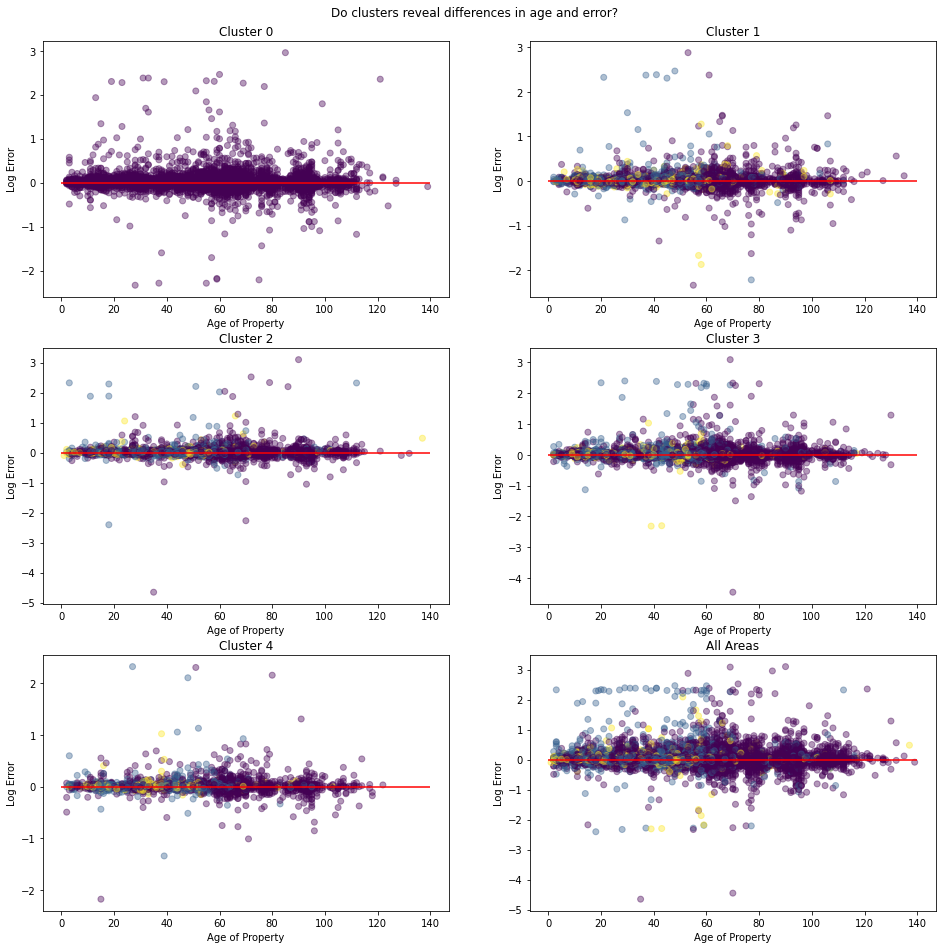

In [58]:
# graph the relationship between age and log error for each area cluster
explore.plot_age_error(X_train, y_train)

#### Statistical Testing

- H0: There is no relationship between the age of the home and the log error.
- Ha: There is a relationship between the age of the home and the log error.

In [59]:
# conduct statistical test for relationship between age and logerror overall
explore.spearman_test(X_train.age, y_train.logerror)

We reject the null hypothesis.


(-0.05153448474833123, 2.389168060893336e-19)

- Spearman's correlation test shows that there is a relationship between age and log error, but the correlation is very small (-0.05).

### What is the relationship between square feet and log error? Do size clusters have a large impact on the overall log error?

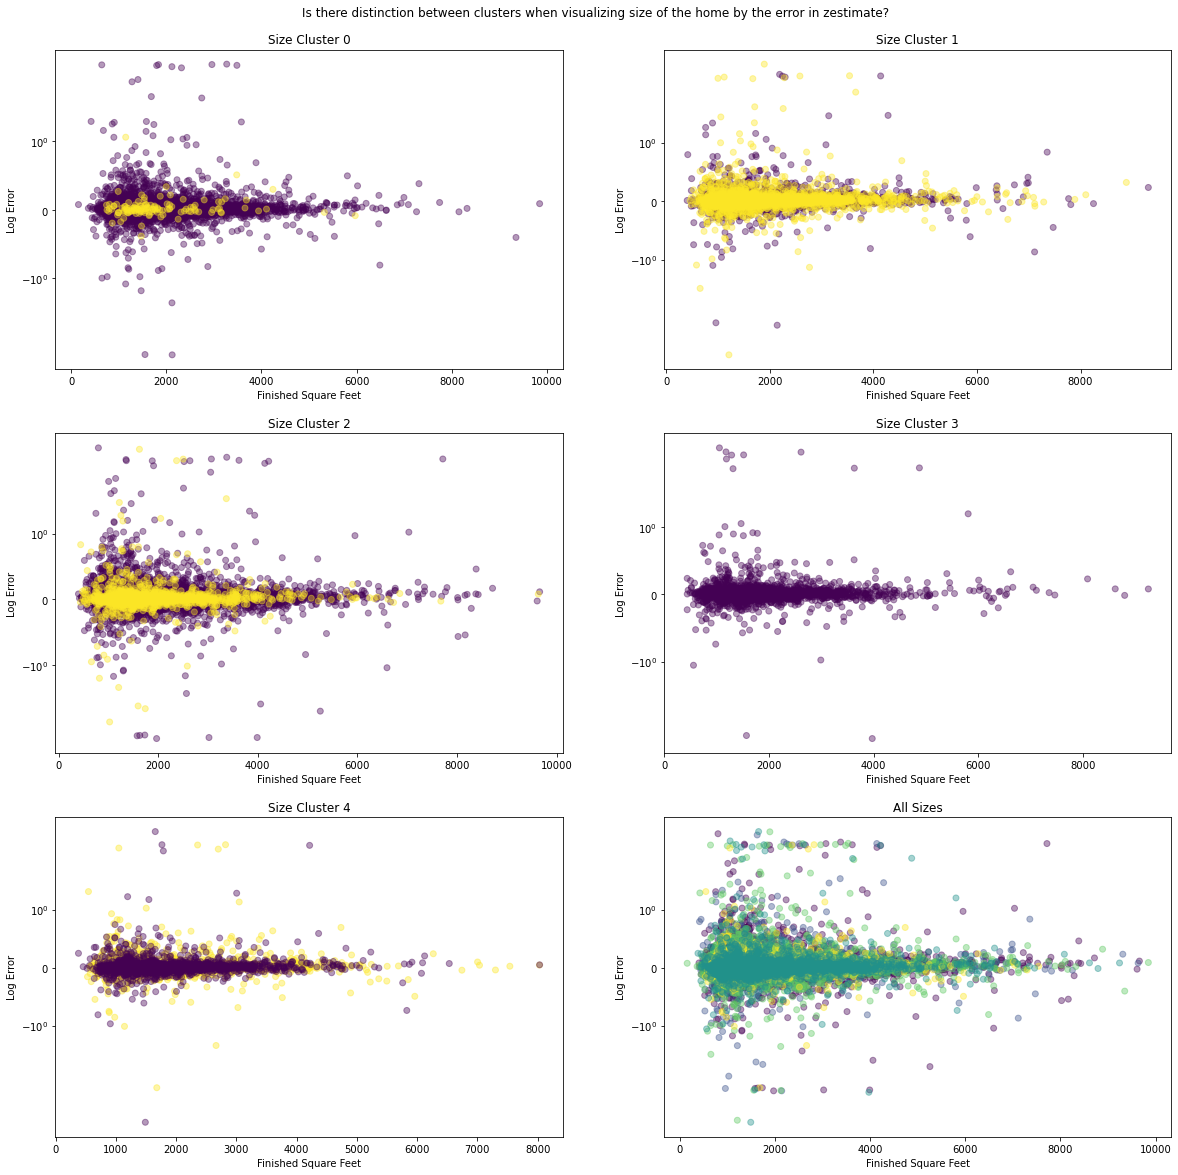

In [60]:
# graph the relationship between square footage and log error for each size cluster
explore.plot_size_error(X_train, y_train)

#### Statistical Testing

- H0: There is no relationship between the number of square feet and log error.
- Ha: There is a relationship between the number of square feet and log error.

In [61]:
# test the relationship between square footage and log error
explore.spearman_test(X_train.calculatedfinishedsquarefeet, y_train.logerror)

We reject the null hypothesis.


(0.07519433120884413, 2.1380267915127974e-39)

- Spearman's correlation test confirms a relationship between square footage and log error, but once again the correlation coefficient is very small.

### Does the location have an effect on log error? Where does the most log error occur?

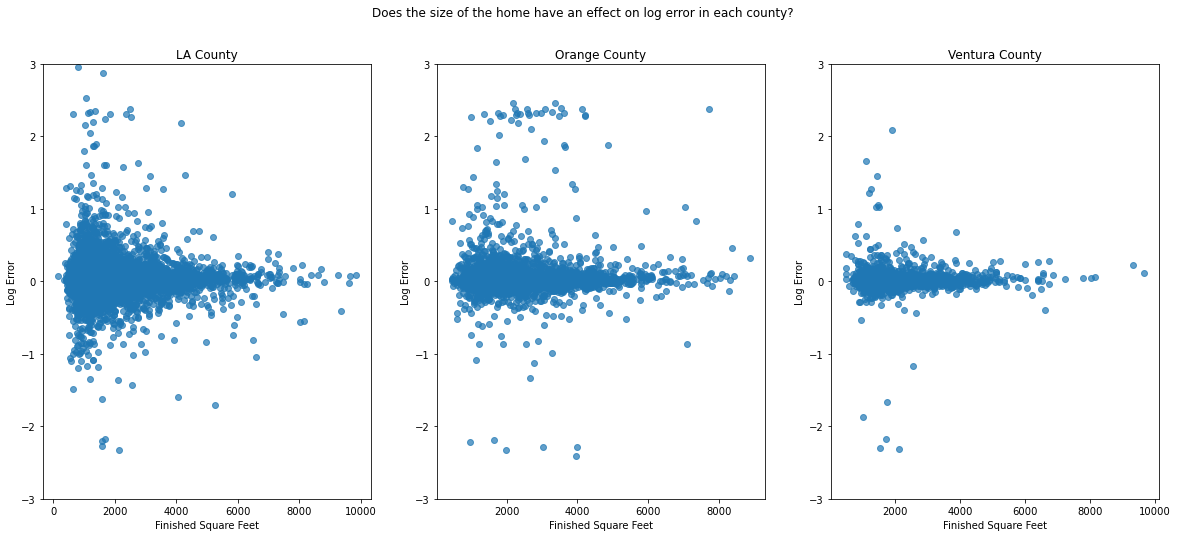

In [62]:
# graph the relationship between square footage and log error for each county
explore.plot_size_county_error(X_train, y_train)

In [63]:
# conduct ANOVA statistical test for significance for square footage and log error between counties
explore.anova_sqft_fips(X_train)

We reject the null hypothesis that there is no difference in square footage of the home between counties.


(468.40662499991384, 4.400274459330453e-201)

- Analysis of variance shows a significant difference in log error between counties.

### Exploration Takeaways

- Analysis of variance shows a significant difference in home square footage between counties.
- Initial exploration showed a moderate relationship between the size of the home and the home’s age, with Los Angeles County having the largest number of older homes. 
- The age and size of the home showed statistical significance to log error, but indicated a weak relationship.

## Modeling

- Select features for modeling

In [64]:
# select features for modeling and assign to a variable
train_df = X_train[['scaled_calculatedfinishedsquarefeet', 'scaled_bathroomcnt', 'scaled_age',
                        'size_cluster', 'area_cluster']]
validate_df = X_validate[['scaled_calculatedfinishedsquarefeet', 'scaled_bathroomcnt', 'scaled_age', 
                        'size_cluster', 'area_cluster']]
test_df = X_test[['scaled_calculatedfinishedsquarefeet', 'scaled_bathroomcnt', 'scaled_age',
                        'size_cluster', 'area_cluster']]

In [65]:
# establish a baseline using logerror
baseline = y_train.logerror.mean()

In [66]:
# create a new column for baseline in train set
train_df['baseline'] = baseline

In [67]:
# create a new column for baseline in validate set
validate_df['baseline'] = baseline
RMSE_baseline = sqrt(mean_squared_error(y_train.logerror, train_df.baseline))
RMSE_baseline

0.17856186076661862

In [68]:
# fit and predict four models using selected features
m1 = model.lasso_lars_model(train_df, validate_df, y_train, y_validate, 1.0)
m2 = model.glm_model(train_df, validate_df, y_train, y_validate, 0, 1)
m3 = model.poly_lm(train_df, validate_df, y_train, y_validate, 2)
m4 = model.lrm(train_df, validate_df, y_train, y_validate)

In [69]:
# show the performance for each model
model.model_performance(m1,m2,m3,m4)

,Model,Train RMSE,Validate RMSE,r2 score,Better than Baseline,RMSE Difference
0,Lasso Lars,0.1786,0.1582,0.0000,True,0.0000
1,Tweedie Regressor,0.1786,0.1582,0.0001,True,0.0000
2,Poly Linear Regression,0.1784,0.1580,0.0018,True,0.0002
3,OLS,0.1785,0.1580,0.0011,True,0.0001


In [70]:
# refit and predict four models using the absolute value of log error
m1 = model.lasso_lars_model(train_df, validate_df, np.absolute(y_train), np.absolute(y_validate), 1.0)
m2 = model.glm_model(train_df, validate_df, np.absolute(y_train), np.absolute(y_validate), 2, 1)
m3 = model.poly_lm(train_df, validate_df, np.absolute(y_train), np.absolute(y_validate), 2)
m4 = model.lrm(train_df, validate_df, np.absolute(y_train), np.absolute(y_validate))

In [71]:
# show each model's performance
model.model_performance(m1,m2,m3,m4)

,Model,Train RMSE,Validate RMSE,r2 score,Better than Baseline,RMSE Difference
0,Lasso Lars,0.1638,0.1435,0.0000,True,0.0092
1,Tweedie Regressor,0.1638,0.1435,0.0005,True,0.0093
2,Poly Linear Regression,0.1624,0.1426,0.0174,True,0.0107
3,OLS,0.1626,0.1427,0.0148,True,0.0104


## Test the Best Model

In [72]:
# fit the features to polynomial regression
pf = PolynomialFeatures(degree=2)
pf.fit(train_df)
pf.transform(validate_df)

array([[1.00000000e+00, 1.10045380e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.00839601e-04],
       [1.00000000e+00, 1.81827558e-01, 3.33333333e-01, ...,
        0.00000000e+00, 0.00000000e+00, 3.00839601e-04],
       [1.00000000e+00, 2.32570132e-01, 3.33333333e-01, ...,
        0.00000000e+00, 0.00000000e+00, 3.00839601e-04],
       ...,
       [1.00000000e+00, 1.86674917e-01, 3.33333333e-01, ...,
        4.00000000e+00, 3.46894566e-02, 3.00839601e-04],
       [1.00000000e+00, 6.60066007e-02, 0.00000000e+00, ...,
        4.00000000e+00, 3.46894566e-02, 3.00839601e-04],
       [1.00000000e+00, 1.83787129e-01, 1.66666667e-01, ...,
        4.00000000e+00, 3.46894566e-02, 3.00839601e-04]])

In [73]:
# create a placeholder column for test; this will be replaced with predicted values later
test_df['yhat'] = baseline

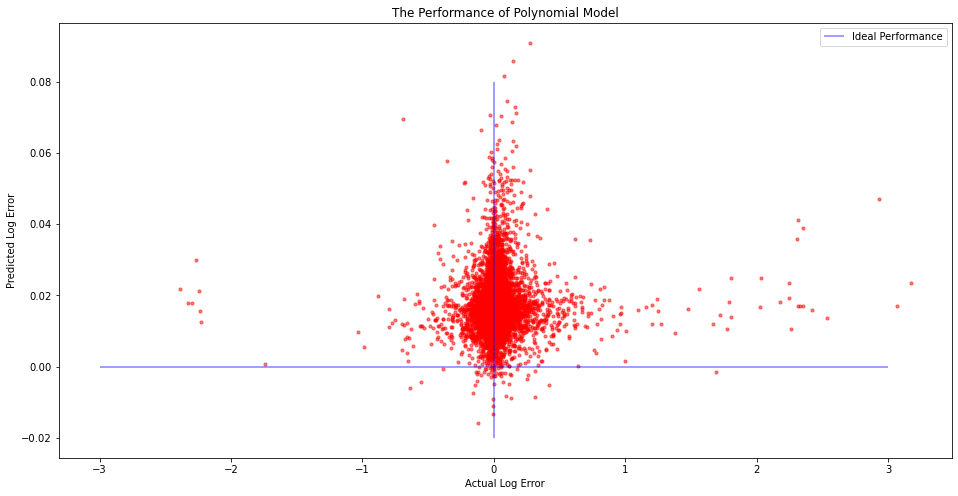

(0.1741752971884493, 0.002299462905406613)

In [74]:
# test the polynomial regression and graph the results; output RMSE and r2
model.test_poly_lm(train_df, validate_df, test_df, y_train, y_validate, y_test, 2)

#### Test Findings:

- The linear regression with squared polynomial features performed above baseline with an RMSE of 0.174, which was  0.004 less error than the baseline prediction. 
- The model performed better on validate than on train, indicating that the model was not overfit to the training dataset.

## Conclusion and Recommendations

- All of the models performed very close to baseline, indicating that the new models with the selected features do not outperform Zillow’s current model. 

- Our recommendation would be to test Zillow’s current model using the absolute value of the log error if it does not do so already. 

- If we had more time, we would train the models after removing the homes that had the largest error to see how much the log error outliers affected the model. We would also see if clustering with log error as a feature can tell us more about why the model cannot accurately predict certain home values.